In [1]:
import os
import sys
from pathlib import Path

from pyarrow.dataset import dataset

# setting proper working directory
PROJECT_DIRECTORY = Path(os.path.abspath('')).resolve().parents[0]
sys.path.extend([str(PROJECT_DIRECTORY)])

print(f'Python {sys.version} on {sys.platform}')
print('Project directory: ', PROJECT_DIRECTORY)

Python 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)] on win32
Project directory:  C:\Users\s8347434\Documents\RecBole-GNN


In [2]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from recbole_gnn.config import Config
from recbole_gnn.utils import create_dataset
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import gaussian_kde

## Read and Transform Benchark Datasets

In [262]:
als_df = pd.read_csv("../eval/log/Benchmark/ALS-Benchmark.csv", sep="\t")
asym_user_df = pd.read_csv("../eval/log/Benchmark/AsymKNNUser-Benchmark.csv", sep="\t")
asym_item_df = pd.read_csv("../eval/log/Benchmark/AsymKNNItem-Benchmark.csv", sep="\t")
bpr_df = pd.read_csv("../eval/log/Benchmark/BPR-Benchmark.csv", sep="\t")
ngcf_df = pd.read_csv("../eval/log/Benchmark/NGCF-Benchmark.csv", sep="\t")
lightgcn_df = pd.read_csv("../eval/log/Benchmark/LightGCN-Benchmark.csv", sep="\t")
sgl_df = pd.read_csv("../eval/log/Benchmark/SGL-Benchmark.csv", sep="\t")
xsimgcl_df = pd.read_csv("../eval/log/Benchmark/XSimGCL-Benchmark.csv", sep="\t")
pop_df = pd.read_csv("../eval/log/Benchmark/Pop-Benchmark.csv", sep="\t")

In [141]:
overall_df = pd.concat([als_df, asym_user_df, asym_item_df, bpr_df, ngcf_df, lightgcn_df, sgl_df, xsimgcl_df, pop_df])
overall_df.to_csv(f'log/Benchmark/Overall-Benchmark.csv', sep='\t', index=False)

In [221]:
# Function to process columns starting with 'best_user_' or 'worst_user_'
def process_user_columns(df):
    for col in df.columns:
        if col.startswith('best_user_') or col.startswith('worst_user_'):
            # Apply transformation for each row in the selected columns
            df[col] = df[col].apply(ast.literal_eval)
                
    df['dataset'] = df['dataset'].str.extract(r'-(\d+)$').astype(int)
    
    return df

In [143]:
overall_df = process_user_columns(overall_df)

#### Translate the userIDs into the userIDs out of the original dataset

In [264]:
def translate_userids(data, num_datasets):      
    # Extract columns ending with @[10]
    columns_to_process = [col for col in data.columns if col.endswith("@[10]")]
    
    for index, row in tqdm(data.head(num_datasets).iterrows()):
        # configurations initialization
        FILENAME = PROJECT_DIRECTORY / f"asset/data/real-life-atomic-splits/real-life-atomic-100000-{index+1}/real-life-atomic-100000-{index+1}.inter"
        db = pd.read_csv(FILENAME, sep="\t", encoding="utf-8")
        
        # Create a mapping dictionary
        translation_dict = dict(zip(db["user_id:token"], db["userID:token"]))
                
        # Process each column
        for col in columns_to_process:
            # Parse the string entries and extract the user IDs
            data.at[index, col] = [
                    {translation_dict[int(list(entry.keys())[0])] : float(list(entry.values())[0])}
                    for entry in row[col]
                ]
            
    return data

In [265]:
als_df = translate_userids(als_df, 177)

177it [00:15, 11.55it/s]


#### Calculate the popularity of each user's interactions

In [163]:
def get_all_users_popularity(file_path, num_datasets):    
    if not os.path.isfile(file_path):
        print("File does not exist, calculate all user's popularity for each dataset..")
        
        # Initialize DataFrame with pre-defined size and columns
        df = pd.DataFrame({'dataset': range(1, num_datasets + 1)})        
        df['user_popularity'] = [{} for _ in range(num_datasets)]     
        
        # Loop through each dataset and compute user popularity
        for i in tqdm(range(num_datasets)):
            FILENAME = PROJECT_DIRECTORY / f"asset/data/real-life-atomic-splits/real-life-atomic-100000-{i+1}/real-life-atomic-100000-{i+1}.inter"
            db = pd.read_csv(FILENAME, sep="\t", encoding="utf-8")
            
            # Filter users with less than 20 interactions
            db['interaction_count'] = db.groupby("userID:token")["itemID:token"].transform('count')
            filtered_df = db[db['interaction_count'] >= 20].copy()
            
            # Calculate item popularity
            item_popularity = filtered_df.groupby("itemID:token")["userID:token"].nunique()
            
            # Map item popularity back to filtered_df safely
            filtered_df.loc[:, 'item_popularity'] = filtered_df["itemID:token"].map(item_popularity)
            
            # Compute user average popularity
            user_avg_popularity = filtered_df.groupby("userID:token")['item_popularity'].agg(['mean', 'median'])
            
            # Compute user popularity dictionary
            all_users_popularity_dict = {
                user_id: (row['mean'], row['median']) 
                for user_id, row in user_avg_popularity.iterrows()
            }
            
            # Assign the dictionary to the DataFrame
            df.at[i, 'user_popularity'] = all_users_popularity_dict
        
        # Save the DataFrame to a file for future use
        df.to_csv(file_path, sep='\t', index=False)

    else:        
        print(f"File exists! Load file from {file_path}")
        # Load the existing DataFrame
        df = pd.read_csv(file_path, sep='\t') 
        # Convert the user_popularity column back to dictionaries
        if 'user_popularity' in df.columns:
            df['user_popularity'] = df['user_popularity'].apply(ast.literal_eval)  
    
    return df

In [164]:
file_path = "../asset/data/real-life-atomic-splits/user_popularity.csv"
popularity_dict = get_all_users_popularity(file_path, num_datasets=177)

File does not exist, calculate all user's popularity for each dataset..


100%|██████████| 177/177 [00:54<00:00,  3.25it/s]


In [292]:
def get_user_popularity(df, all_users_popularity_dict):
    
    # Initialize new columns with empty lists
    df['user_average_popularity'] = [{} for _ in range(len(df))]
    df['user_interactions'] = [{} for _ in range(len(df))]
            
    # Loop through each row
    for index, row in tqdm(df.head(2).iterrows()):
        # configurations initialization
        FILENAME = PROJECT_DIRECTORY / f"asset/data/real-life-atomic-splits/real-life-atomic-100000-{index+1}/real-life-atomic-100000-{index+1}.inter"
        db = pd.read_csv(FILENAME, sep="\t", encoding="utf-8")
        
        # Filter users with less than 20 interactions
        db['interaction_count'] = db.groupby("userID:token")["itemID:token"].transform('count')
        filtered_df = db[db['interaction_count'] >= 20].copy()
        all_users_interactions_dict = filtered_df.groupby("userID:token")['interaction_count'].first()
                        
        # Extract unique user IDs from best_user_ and worst_user_ columns
        user_ids = set()  # Use a set to ensure uniqueness
        for col in df.columns:
            if col.startswith('best_user_') or col.startswith('worst_user_'):
                # Extract user IDs from the list of dictionaries
                for entry in row[col]:  # Assuming each entry is a list of dictionaries
                    user_ids.add(int(list(entry.keys())[0]))  # Add user ID (the key) to the set
                                                            
        # Prepare dictionaries of user IDs and their corresponding values
        user_popularity_dict = [{user_id: all_users_popularity_dict.at[index,'user_popularity'][user_id]} for user_id in user_ids]
        user_interactions_dict = [{user_id: all_users_interactions_dict[user_id]} for user_id in user_ids]
        
        # Assign the dictionaries to the new columns
        df.at[index, 'user_mean_popularity'] = user_popularity_dict
        df.at[index, 'user_mean_popularity_max'] = np.min(list(all_users_popularity_dict.at[index,'user_popularity'].values()[0]))
        df.at[index, 'user_mean_popularity_min'] = np.max(list(all_users_popularity_dict.at[index,'user_popularity'].values()[0]))
        df.at[index, 'user_median_popularity'] = user_popularity_dict
        df.at[index, 'user_median_popularity_max'] = np.min(list(all_users_popularity_dict.at[index,'user_popularity'].values()[1]))
        df.at[index, 'user_median_popularity_min'] = np.max(list(all_users_popularity_dict.at[index,'user_popularity'].values()[1]))
        df.at[index, 'user_interactions'] = user_interactions_dict
        df.at[index, 'user_interactions_mean'] = user_interactions_dict.mean()
        df.at[index, 'user_interactions_median'] = user_interactions_dict.median()
        df.at[index, 'user_interactions_min'] = all_users_interactions_dict.min()
        df.at[index, 'user_interactions_max'] = all_users_interactions_dict.max()
        
    return df

In [293]:
# NOTE: takes approx. 10min
example = get_user_popularity(als_df, popularity_dict)

2it [00:03,  1.95s/it]


In [294]:
print(example.loc[1, "user_average_popularity"])

[{1: 3.478110599078341}, {4: 5.275147928994083}, {523: 87.61538461538461}, {545: 9.193548387096774}, {1074: 102.37272727272727}, {575: 100.03333333333333}, {63: 146.05714285714285}, {81: 89.69148936170212}, {609: 121.08695652173913}, {112: 146.05714285714285}, {627: 94.71698113207547}, {632: 9.931034482758621}, {633: 15.0}, {635: 5.137254901960785}, {637: 78.73239436619718}, {639: 83.21052631578948}, {642: 49.916666666666664}, {644: 131.4102564102564}, {645: 13.745098039215685}, {698: 129.9090909090909}, {718: 23.90625}, {722: 8.8125}, {723: 6.444444444444445}, {731: 138.14285714285714}, {736: 47.708333333333336}, {238: 93.62162162162163}, {780: 41.1625}, {783: 5.081081081081081}, {784: 19.7}, {786: 14.26086956521739}, {830: 76.98830409356725}, {336: 124.6842105263158}, {341: 96.0909090909091}, {876: 53.40384615384615}, {364: 18.073684210526316}, {877: 2.864864864864865}, {878: 7.403225806451613}, {880: 67.2}, {369: 138.09756097560975}, {886: 2.5}, {887: 15.681818181818182}, {378: 71.4

[{1: 3.478110599078341}, {4: 5.275147928994083}, {523: 87.61538461538461}, {545: 9.193548387096774}, {1074: 102.37272727272727}, {575: 100.03333333333333}, {63: 146.05714285714285}, {81: 89.69148936170212}, {609: 121.08695652173913}, {112: 146.05714285714285}, {627: 94.71698113207547}, {632: 9.931034482758621}, {633: 15.0}, {635: 5.137254901960785}, {637: 78.73239436619718}, {639: 83.21052631578948}, {642: 49.916666666666664}, {644: 131.4102564102564}, {645: 13.745098039215685}, {698: 129.9090909090909}, {718: 23.90625}, {722: 8.8125}, {723: 6.444444444444445}, {731: 138.14285714285714}, {736: 47.708333333333336}, {238: 93.62162162162163}, {780: 41.1625}, {783: 5.081081081081081}, {784: 19.7}, {786: 14.26086956521739}, {830: 76.98830409356725}, {336: 124.6842105263158}, {341: 96.0909090909091}, {876: 53.40384615384615}, {364: 18.073684210526316}, {877: 2.864864864864865}, {878: 7.403225806451613}, {880: 67.2}, {369: 138.09756097560975}, {886: 2.5}, {887: 15.681818181818182}, {378: 71.45454545454545}, {379: 35.62162162162162}, {380: 10.23076923076923}, {893: 89.79166666666667}, {381: 5.395833333333333}, {894: 55.6}, {384: 7.516129032258065}, {896: 13.870967741935484}, {386: 7.051282051282051}, {387: 4.158730158730159}, {388: 63.04347826086956}, {390: 22.239436619718308}, {394: 43.916666666666664}, {395: 7.230769230769231}, {398: 136.56}, {911: 24.390243902439025}, {910: 50.392857142857146}, {914: 6.642857142857143}, {924: 73.53030303030303}, {929: 25.247311827956988}, {425: 21.5609756097561}, {426: 16.05217391304348}, {427: 14.571428571428571}, {429: 5.602409638554217}, {432: 25.272727272727273}, {434: 3.161764705882353}, {440: 11.096774193548388}, {443: 8.351851851851851}, {445: 6.454545454545454}, {451: 47.16}, {452: 86.76415094339623}, {453: 71.19047619047619}, {454: 23.958333333333332}, {456: 21.785714285714285}, {458: 19.6}, {462: 11.222222222222221}, {477: 110.33333333333333}]

In [217]:
# Function to plot metrics by dataset with model averages
def plot_metrics_by_dataset(df, metric, dataset_range=None):
    # Ensure the 'metric' column exists in the dataframe
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in dataframe columns.")
    
    if dataset_range:
        lower_bound, upper_bound = dataset_range
        df = df[(df['dataset'] >= lower_bound) & (df['dataset'] <= upper_bound)]

    # Calculate average metric values for each model
    model_averages = df.groupby('Model')[metric].mean()

    # Create the plot using seaborn lineplot
    plt.figure(figsize=(12, 6))
    lineplot = sns.lineplot(x='dataset', y=metric, hue='Model', data=df, marker='o', markersize=6)

    # Retrieve the colors used for each model from the seaborn plot
    handles, labels = lineplot.get_legend_handles_labels()
    color_map = {label: handle.get_color() for label, handle in zip(labels, handles)}

    # Add horizontal lines for model averages with the corresponding model color
    for model, avg in model_averages.items():
        plt.axhline(avg, linestyle='--', color=color_map[model])

    # Customize plot
    plt.title(f'{metric} by Model and Dataset')
    plt.xlabel('Dataset #')
    plt.ylabel(f'{metric}')
    plt.legend(title='Model')

    if dataset_range and dataset_range[1] >= 177:
        xticks = [1] + list(range(10, 177, 10)) + [177]
        plt.xticks(xticks)  # Adjust step size (e.g., 10) for better label visibility

    # Display grid
    plt.grid(True)

    # Display the plot
    plt.show()

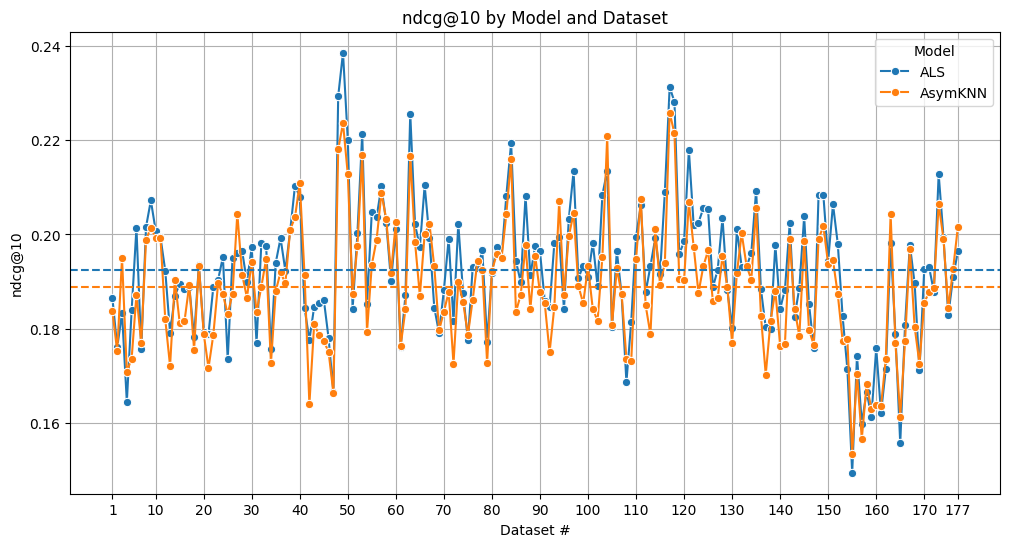

In [218]:
# Example usage: Plot MR@10 and NDCG@10
# Step 1: Combine all DataFrames
df_combined = pd.concat([als_df, asym_user_df], axis=0, ignore_index=True)

plot_metrics_by_dataset(df_combined, "ndcg@10", dataset_range=[1,177])

In [229]:
# Function to plot user characteristics (average popularity or interactions) per dataset
def plot_user_characteristics_per_dataset(df, metric, dataset_range=None):
    # Ensure the metric is either 'user_average_popularity' or 'user_interactions'
    if metric not in ['user_average_popularity', 'user_interactions']:
        raise ValueError(f"Invalid metric '{metric}'. Choose either 'user_average_popularity' or 'user_interactions'.")
    
    # Filter dataframe based on dataset range if provided
    if dataset_range:
        integer1, integer2 = dataset_range
        df = df[(df['dataset'] >= integer1) & (df['dataset'] <= integer2)]
    
    # Extract and flatten the values for the selected metric
    metric_values = []
    datasets = []
    
    for index, row in df.iterrows():
        # For the selected metric column
        for entry in row[metric]:
            metric_values.append(list(entry.values())[0])  # Extract metric value from dict
            datasets.append(row['dataset'])
    
    # Plot the selected metric (either average popularity or interactions)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=datasets, y=metric_values, label=metric.replace('_', ' ').title(), marker='o', markersize=6, ci=None)
    
    # Add the min-max shaded area
    plt.fill_between(
        df['dataset'],
        df['user_interactions_min'],
        df['user_interactions_max'],
        alpha=0.2  # Adjust transparency
    )
    
    # Customize plot
    plt.title(f'{metric.replace("_", " ").title()} by Dataset')
    plt.xlabel('Dataset #')
    plt.ylabel('Value')
    plt.legend(title=metric.replace('_', ' ').title())
    
    if dataset_range and dataset_range[1] >= 177:
        xticks = [1] + list(range(10, 177, 10)) + [177]
        plt.xticks(xticks)  # Adjust step size (e.g., 10) for better label visibility

    # Display grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

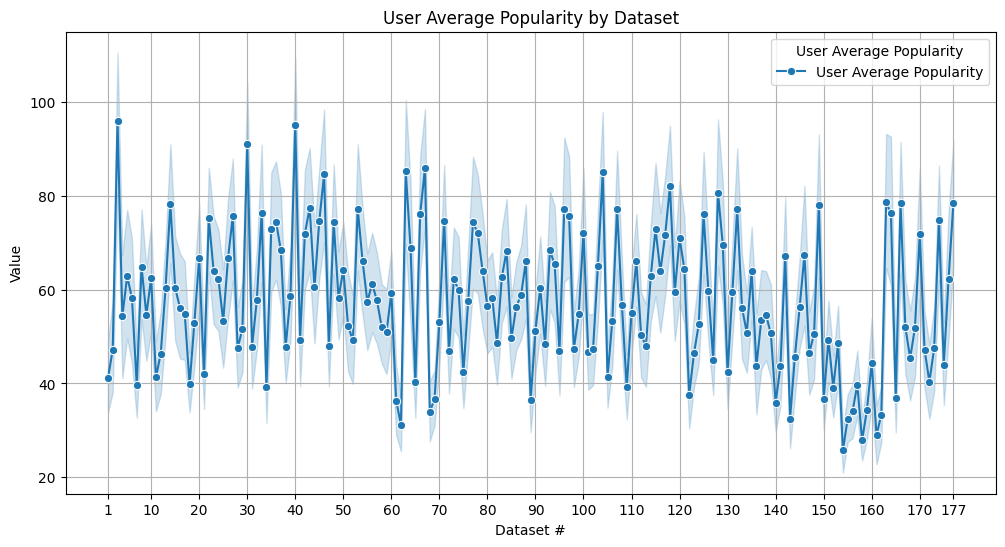

In [230]:
plot_user_characteristics_per_dataset(example, metric="user_average_popularity", dataset_range=[1,177])

In [232]:
def plot_regression(df, metric):
    # Ensure the metric exists in the dataframe
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in dataframe columns.")
    
    # Extract user_average_popularity values from the list of dicts
    user_avg_popularity_values = []
    metric_values = []
    
    for index, row in df.iterrows():
        # Extract the user average popularity (flatten the list of dicts)
        avg_popularity = [list(entry.values())[0] for entry in row['user_average_popularity']]
        user_avg_popularity_values.extend(avg_popularity)  # Flatten the list
        metric_values.extend([row[metric]] * len(avg_popularity))  # Repeat the metric value for each user
    
    # Convert the data into a DataFrame for regression
    regression_data = pd.DataFrame({
        'user_average_popularity': user_avg_popularity_values,
        'metric': metric_values
    })
    
    # Perform linear regression
    X = regression_data[['user_average_popularity']].values.reshape(-1, 1)  # Features
    y = regression_data['metric'].values  # Target
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions from the model
    y_pred = model.predict(X)
    
    # Plot the regression
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of the data
    sns.scatterplot(x='user_average_popularity', y='metric', data=regression_data, color='blue', label='Data', s=100)
    
    # Plot the regression line
    plt.plot(regression_data['user_average_popularity'], y_pred, color='red', label='Regression Line', linewidth=2)
    
    # Customize the plot
    plt.title(f'Regression between user_average_popularity and {metric}')
    plt.xlabel('User Average Popularity')
    plt.ylabel(f'{metric}')
    plt.legend()
    
    # Display grid
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Return model details (coefficients, intercept)
    return model.coef_, model.intercept_

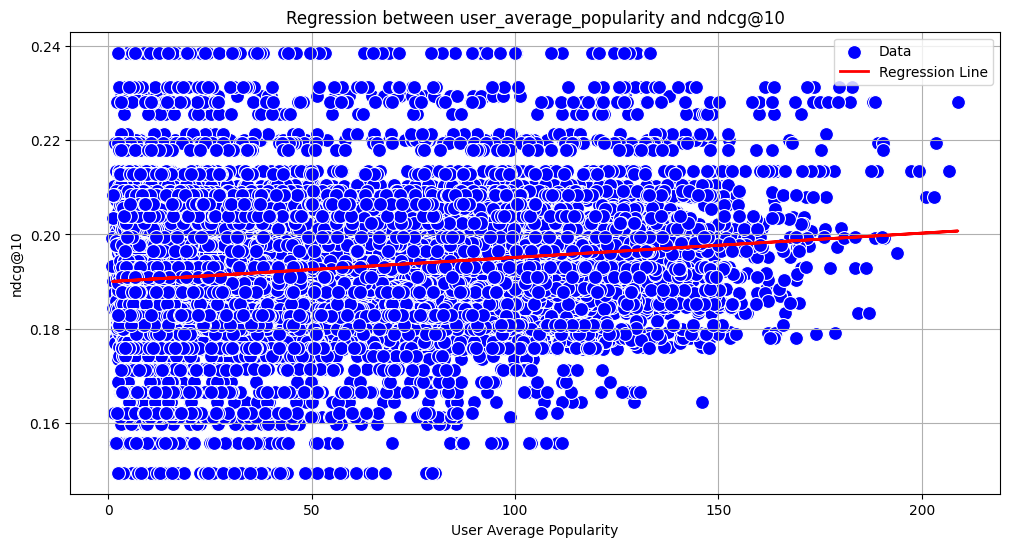

(array([5.14354676e-05]), 0.18998072882666261)

In [234]:
plot_regression(example, 'ndcg@10')

In [249]:
# Function to perform regression and handle skewed data
def plot_regression_with_skew(df, metric):
    # Ensure the metric exists in the dataframe
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in dataframe columns.")
    
    # Extract user_average_popularity values from the list of dicts
    user_avg_popularity_values = []
    metric_values = []
    
    for index, row in df.iterrows():
        # Extract the user average popularity (flatten the list of dicts)
        avg_popularity = [list(entry.values())[0] for entry in row['user_average_popularity']]
        user_avg_popularity_values.extend(avg_popularity)  # Flatten the list
        metric_values.extend([row[metric]] * len(avg_popularity))  # Repeat the metric value for each user
    
    # Convert the data into a DataFrame for regression
    regression_data = pd.DataFrame({
        'user_average_popularity': user_avg_popularity_values,
        'metric': metric_values
    })
    
    # Apply a log transformation to handle skewness (if necessary)
    # Add a small constant to avoid taking the log of zero
    regression_data['user_average_popularity'] = np.log1p(regression_data['user_average_popularity'])
    regression_data['metric'] = np.log1p(regression_data['metric'])
    
    # Perform linear regression
    X = regression_data[['user_average_popularity']].values.reshape(-1, 1)  # Features
    y = regression_data['metric'].values  # Target
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predictions from the model
    y_pred = model.predict(X)
    
    # Plot the regression
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of the data
    sns.scatterplot(x='user_average_popularity', y='metric', data=regression_data, color='blue', label='Data', s=100)
    
    # Plot the regression line
    plt.plot(regression_data['user_average_popularity'], y_pred, color='red', label='Regression Line', linewidth=2)
    
    # Customize the plot
    plt.title(f'Regression between user_average_popularity and {metric} (Log-Transformed)')
    plt.xlabel('Log of User Average Popularity')
    plt.ylabel(f'Log of {metric}')
    plt.legend()
    
    # Display grid
    plt.grid(True)
    
    # Show plot
    plt.show()
    
    # Return model details (coefficients, intercept)
    return model.coef_, model.intercept_

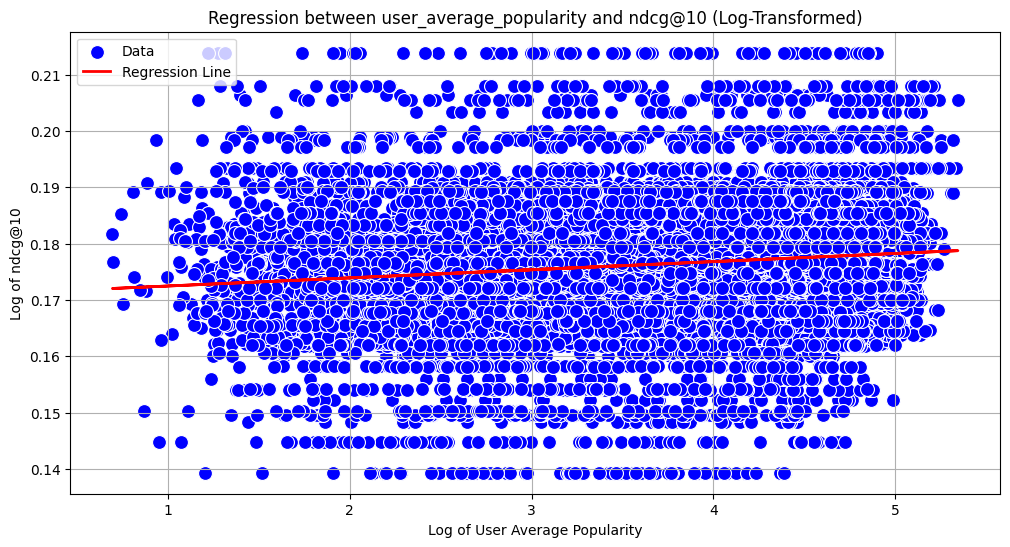

(array([0.00144325]), 0.1710386569440969)

In [250]:
plot_regression_with_skew(example, 'ndcg@10')


In [253]:
# Function to extract values from a list of dictionaries
def extract_values_from_dict_column(df, col):
    values = []
    for index, row in df.iterrows():
        values.extend([list(entry.values())[0] for entry in row[col]])  # Flatten the list of dictionaries and extract values
    return values

# Function to plot a correlation matrix heatmap considering only columns that end with '@10'
def plot_correlation_matrix(df):
    # First, extract the relevant columns that end with '@10'
    relevant_columns = [col for col in df.columns if col.endswith('@10')]

    # Flatten the 'user_average_popularity' and 'user_interactions' columns
    user_avg_popularity_values = extract_values_from_dict_column(df, 'user_average_popularity')
    user_interactions_values = extract_values_from_dict_column(df, 'user_interactions')

    # Create a new DataFrame for the relevant columns and extracted values
    correlation_data = pd.DataFrame({
        'user_average_popularity': user_avg_popularity_values,
        'user_interactions': user_interactions_values
    })
    
    # Extract the '@10' columns and add them to the correlation data
    for col in relevant_columns:
        correlation_data[col] = df[col]

    # Compute the correlation matrix
    correlation_matrix = correlation_data.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f', linewidths=0.5)

    # Customize the plot
    plt.title('Correlation Matrix for Metrics ending with @10')
    plt.tight_layout()

    # Display the plot
    plt.show()

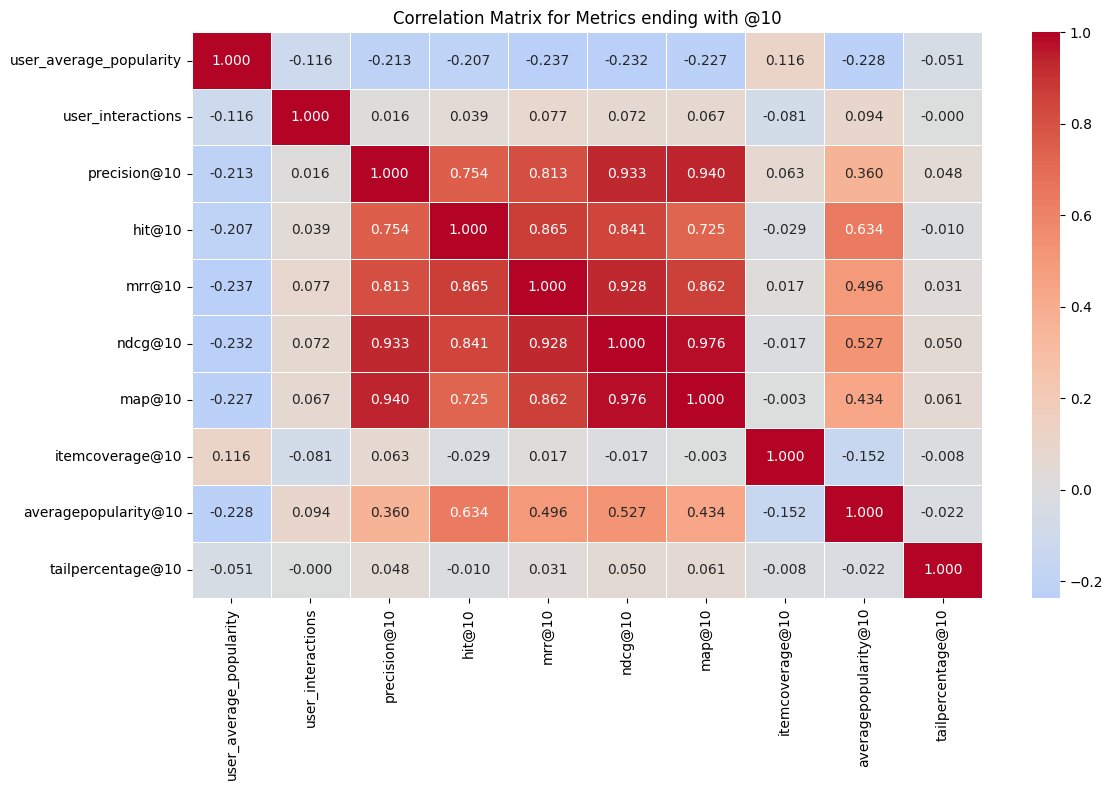

In [254]:
plot_correlation_matrix(example)